# Get data

## Peeringdb

In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


In [2]:
bgp_df = pd.read_csv('../../scripts/as_metrics_with_rpki.csv')

In [3]:
net_df = net_df.merge(bgp_df, how='inner', left_on='asn', right_on='asn')

## Ipinfo Domains

In [4]:
ipinfo_df = pd.read_csv('../../preprocessing/data/ipinfo_domains/ipinfo_domains.csv')
ipinfo_df.head()

,ASN,domains
0,16509,139276485
1,13335,63477595
2,52925,32915972
3,396982,24543491
4,47846,17833760


## Merge data

In [5]:
merged_df = pd.merge(net_df, ipinfo_df, left_on='asn', right_on='ASN', how='left')
merged_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,total_unique_paths,total_peers,rpki_valid,rpki_invalid_as,rpki_invalid_length,rpki_not_found,rpki_total,rpki_valid_share,ASN,domains
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,7611576,113,0,0,0,0,0,0.000000,NaN,NaN
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,7611576,113,4808,1,2,37,4848,0.991749,20940.0,3849287.0
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,7611576,113,2,0,0,0,2,1.000000,NaN,NaN
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,7611576,113,363,0,0,44,407,0.891892,3303.0,46521.0
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,7611576,113,5325,1,0,92,5418,0.982835,22773.0,55711.0


In [6]:

merged_df["info_type"].value_counts()

info_type
Cable/DSL/ISP           11738
NSP                      3826
Content                  2182
Enterprise               1590
Educational/Research     1315
Network Services          747
Non-Profit                543
Government                130
Route Server              100
Route Collector            11
Name: count, dtype: int64

# Evaluate

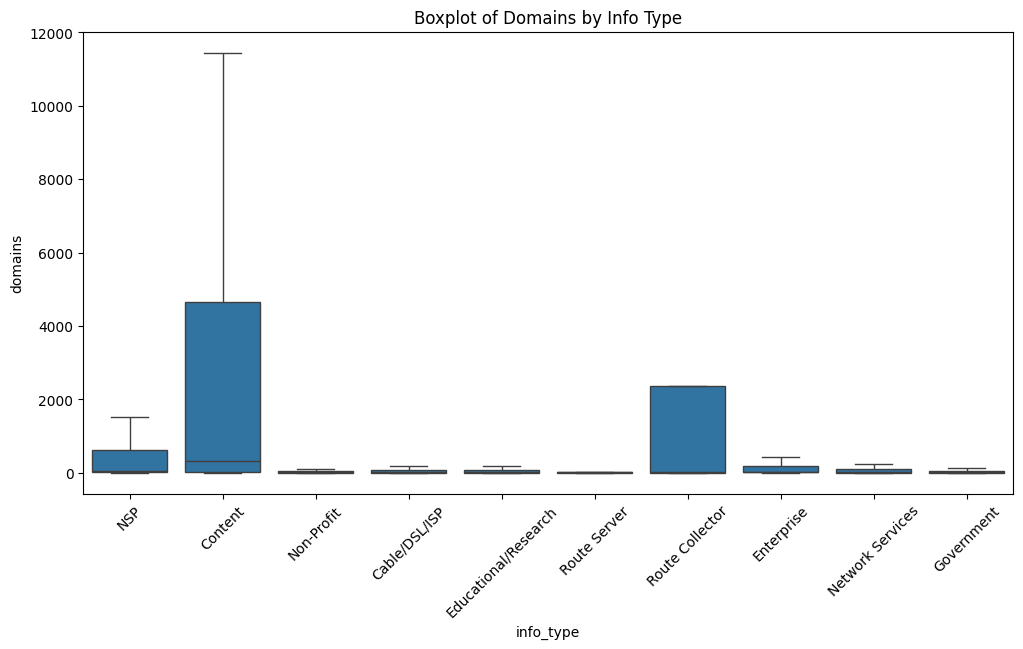

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='info_type', y='domains', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Domains by Info Type')
plt.show()